# Model and Evaluation


## Objectives


- Implement ML pipeline. 
- Implement regression model to predict the sale price of properties,


## Inputs 


- outputs/datasets/datacollection/HousePrices.csv


## Outputs


- Train Set and Test Set. 
- Machine Learning pipeline. 


## CRISP-DM


- "Modelling and Evaluation".

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues'

In [4]:
import numpy as np
import pandas as pd 
df = pd.read_csv("outputs/datasets/datacollection/HousePrices.csv")

print(df.shape)
df.head(5)

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


In [5]:
from sklearn.pipeline import Pipeline

### Data Cleaning
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import MeanMedianImputer

### Feature Engineering
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

### Feature Scaling
from sklearn.preprocessing import StandardScaler

### Feature Selection 
from sklearn.feature_selection import SelectFromModel

### ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor



def PipelineOptimization(model):
  pipeline_base = Pipeline([

    ### Data Cleaning 
    
    ("ArbitraryNumberImputer",ArbitraryNumberImputer(arbitrary_number=0,
                                variables = ['2ndFlrSF', 'EnclosedPorch', 'MasVnrArea', 'WoodDeckSF']) ),

    ("CategoricalEncoder",CategoricalImputer(imputation_method='missing',fill_value='Unf',
                                variables = ['BsmtFinType1', 'GarageFinish'])),

    ("MeanMedianImputer",MeanMedianImputer(imputation_method='median', 
                                variables = ['BedroomAbvGr', 'GarageYrBlt', 'LotFrontage']) ),  
    ### Feature Engineering 
    ("Ordinalencoder", OrdinalEncoder(encoding_method='arbitrary', 
                          variables = ["GarageFinish", "KitchenQual", "BsmtExposure", "BsmtFinType1"]) ),
                          
    ("LogTransformer", vt.LogTransformer(
                         variables = ['1stFlrSF', 'GrLivArea', 'LotArea', 'LotFrontage']) ),

    ("PowerTransformer", vt.PowerTransformer(
                         variables = ['BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'GrLivArea', 'MasVnrArea', 'OpenPorchSF' ]) ),
      
    ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables=None, method="spearman", 
                                                        threshold=0.8, selection_method="variance") ),
    ("feat_scaling",StandardScaler() ),

    ("feat_selection",SelectFromModel(model) ),

    ("model",model ),  
     ])

  return pipeline_base

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [6]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineOptimization(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'],axis=1),
                                    df['SalePrice'],
                                    test_size = 0.2,
                                    random_state = 0,
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


In [8]:
# Dictionary that maps model to their corresponding scikit-learn or XGBoost regression models.

models_quick_search = {

    # Linear Regression model. 
    "LinearRegression": LinearRegression(),

    # Decision Tree Regressor model with a fixed random state for reproducibility. 
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),

    # Which is an ensemble method using multiple decision trees.
    "RandomForestRegressor": RandomForestRegressor(random_state=0),

    # Another ensemble method similar to Random Forest, but with no more randomness.
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),

    # Which combines multiple weak learners to form a stronger model.
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),

    # Another ensemble method that builds trees sequentially to correct previous errors.
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),

    # A powerful gradient boosting framework that is often more efficient and accurate. 
    "XGBRegressor": XGBRegressor(random_state=0),
}

# Dictionary that maps each model name to an empty dictionary or parameters. 
# This is used to store or pass hyperparameters when tuning or training the models.
params_quick_search = {
    "LinearRegression": {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [9]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in

In [10]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by="mean_score")
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.673387,0.814882,0.876227,0.072298
0,LinearRegression,0.724991,0.804877,0.845233,0.044795
2,RandomForestRegressor,0.696213,0.7895,0.832177,0.048822
5,GradientBoostingRegressor,0.611907,0.767946,0.831455,0.080929
4,AdaBoostRegressor,0.633396,0.754165,0.798679,0.061059
6,XGBRegressor,0.516448,0.648972,0.751455,0.087389
1,DecisionTreeRegressor,0.49583,0.591375,0.725724,0.081393


In [11]:
# Define a list of models
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0)
}

# Define a dictionary for parameter grids to corresponding to the model names
params_search = {
    "ExtraTreesRegressor": {
        "model__n_estimators": [50, 100, 150],
        "model__max_depth": [None, 3, 15],
        "model__min_samples_split": [2, 50],
        "model__min_samples_leaf": [1, 50]
    }
}

In [12]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

In [13]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by="mean_score")
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
25,ExtraTreesRegressor,0.696498,0.820223,0.876907,0.063455,15,1,2,100
24,ExtraTreesRegressor,0.69406,0.817876,0.87562,0.063808,15,1,2,50
26,ExtraTreesRegressor,0.685224,0.817874,0.878156,0.068064,15,1,2,150
2,ExtraTreesRegressor,0.675595,0.815054,0.87541,0.071224,None,1,2,150
1,ExtraTreesRegressor,0.673387,0.814882,0.876227,0.072298,None,1,2,100
5,ExtraTreesRegressor,0.765841,0.81409,0.854839,0.039357,None,1,50,150
29,ExtraTreesRegressor,0.765601,0.814036,0.854811,0.03941,15,1,50,150
4,ExtraTreesRegressor,0.767574,0.813681,0.853827,0.038001,None,1,50,100
28,ExtraTreesRegressor,0.767574,0.813675,0.853797,0.037994,15,1,50,100
0,ExtraTreesRegressor,0.667489,0.812557,0.874266,0.07435,None,1,2,50


In [14]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

In [15]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': 15,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

In [16]:
regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
regressor_pipeline

Pipeline(steps=[('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'EnclosedPorch',
                                                   'MasVnrArea',
                                                   'WoodDeckSF'])),
                ('CategoricalEncoder',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['BsmtFinType1',
                                               'GarageFinish'])),
                ('MeanMedianImputer',
                 MeanMedianImputer(variables=['BedroomAbvGr', 'GarageYrBlt',
                                              'LotFrontage'])),
                (...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                                     'OverallCond',
                                                     'OverallQual',
                                                     'TotalBsmtSF',
                                                     'WoodDeckSF', 'YearBuilt',
                                                     'YearRemodAdd'])),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model', ExtraTreesRegressor(max_depth=15, random_state=0))])

* These are the 6 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageArea', 'YearBuilt', 'YearRemodAdd']


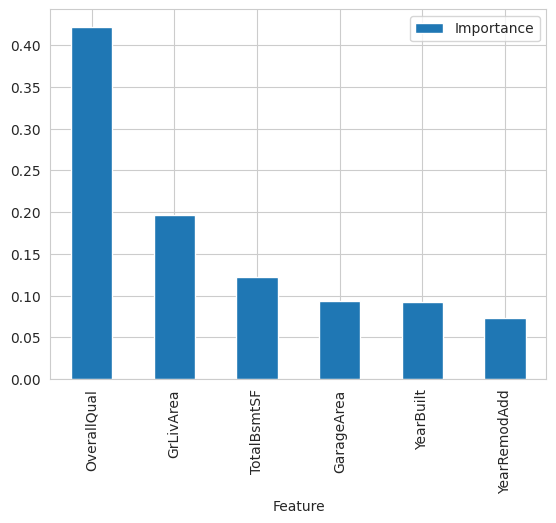

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Define the number of data cleaning and feature engineering steps
data_cleaning_feat_eng_steps = 7 

# Extract columns after data cleaning and feature engineering steps
columns_after_cleaning = (
    Pipeline(regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
    .transform(X_train)
    .columns
)

# Get the list of selected features
selected_features_mask = regressor_pipeline["feat_selection"].get_support()
best_features = columns_after_cleaning[selected_features_mask].tolist()

# Create a DataFrame to display feature importance
df_feature_importance = (
    pd.DataFrame({
        "Feature": columns_after_cleaning[selected_features_mask],
        "Importance": regressor_pipeline["model"].feature_importances_
    })
    .sort_values(by="Importance", ascending=False)
)

# Print most important features
print(
    f"* These are the {len(best_features)} most important features in descending order. "
    f"The model was trained on them: \n{df_feature_importance['Feature'].tolist()}"
)

# Plot feature importance
df_feature_importance.plot(kind="bar", x="Feature", y="Importance")
plt.show()

In [22]:
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_regression_model(X_train, y_train, X_test, y_test, model):
    """
    Evaluate the performance of a regression model on both training and test sets.
    """
    print("Model Evaluation\n")
    evaluate_on_dataset(X_train, y_train, model, dataset_name="Train Set")
    evaluate_on_dataset(X_test, y_test, model, dataset_name="Test Set")

def evaluate_on_dataset(X, y, model, dataset_name="Dataset"):
    """
    Evaluate the regression performance on a single dataset.
    """
    predictions = model.predict(X)
    r2 = r2_score(y, predictions).round(3)
    mae = mean_absolute_error(y, predictions).round(3)
    print(f"* {dataset_name}")
    print(f'  R2 Score: {r2}')
    print(f'  Mean Absolute Error: {mae}\n')

def plot_regression_results(X_train, y_train, X_test, y_test, model, alpha=0.5):
    """
    Plot actual vs predicted values for training and test sets.
    """
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Train set plot
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_title("Train Set")
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predicted")

    # Test set plot
    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_title("Test Set")
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predicted")

    plt.tight_layout()
    plt.show()


Model Evaluation 

* Train Set
R2 Score: 0.999
Mean Absolute Error: 1700.058


* Test Set
R2 Score: 0.859
Mean Absolute Error: 19699.173




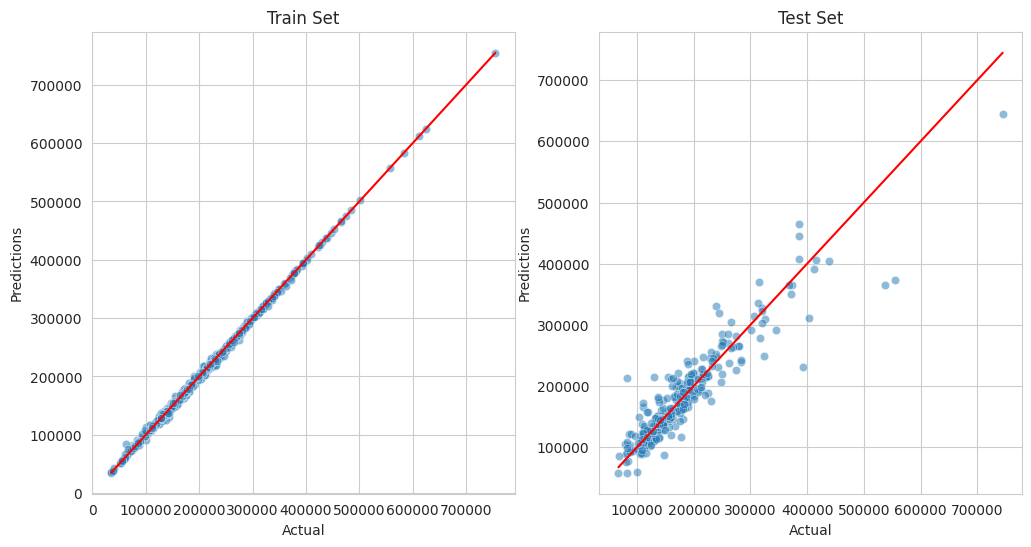

In [29]:
def evaluate_regression_model(X_train, y_train, X_test, y_test, regressor):
    # Evaluate regression performance
    regression_performance(X_train, y_train, X_test, y_test, regressor)

    # Generate evaluation plots
    regression_evaluation_plots(X_train, y_train, X_test, y_test, regressor)

# Call the combined function
evaluate_regressor_performance(X_train, y_train, X_test, y_test, regressor_pipeline)

In [32]:
from sklearn.decomposition import PCA

def PipelineOptimization(model):
  pipeline_base = Pipeline([

    ### Data Cleaning 
    
    ("ArbitraryNumberImputer",ArbitraryNumberImputer(arbitrary_number=0,
                                variables = ['2ndFlrSF', 'EnclosedPorch', 'MasVnrArea', 'WoodDeckSF']) ),

    ("CategoricalEncoder",CategoricalImputer(imputation_method='missing',fill_value='Unf',
                                variables = ['BsmtFinType1', 'GarageFinish'])),

    ("MeanMedianImputer",MeanMedianImputer(imputation_method='median', 
                                variables = ['BedroomAbvGr', 'GarageYrBlt', 'LotFrontage']) ),  
    ### Feature Engineering 
    ("Ordinalencoder", OrdinalEncoder(encoding_method='arbitrary', 
                          variables = ["GarageFinish", "KitchenQual", "BsmtExposure", "BsmtFinType1"]) ),
                          
    ("LogTransformer", vt.LogTransformer(
                         variables = ['1stFlrSF', 'GrLivArea', 'LotArea', 'LotFrontage']) ),

    ("PowerTransformer", vt.PowerTransformer(
                         variables = ['BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'GrLivArea', 'MasVnrArea', 'OpenPorchSF' ]) ),
      
    ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables=None, method="spearman", 
                                                        threshold=0.8, selection_method="variance") ),
    ("feat_scaling",StandardScaler() ),

    ("feat_selection",SelectFromModel(model) ),

    ("model",model ),  
     ])

  return pipeline_base

In [34]:
# Code is being resued from above. 

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


In [35]:
models_search

{'ExtraTreesRegressor': ExtraTreesRegressor(random_state=0)}

In [36]:
best_parameters

{'model__max_depth': 15,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

In [39]:
params_search = {
    "ExtraTreesRegressor": {"model__n_estimators": [50, 100, 150],
    "model__max_depth": [None, 3, 15],
    "model__min_samples_split": [2, 50],
    "model__min_samples_leaf": [1, 50],
    }
}

In [40]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

In [42]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by="mean_score")
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
25,ExtraTreesRegressor,0.696498,0.820223,0.876907,0.063455,15,1,2,100
24,ExtraTreesRegressor,0.69406,0.817876,0.87562,0.063808,15,1,2,50
26,ExtraTreesRegressor,0.685224,0.817874,0.878156,0.068064,15,1,2,150
2,ExtraTreesRegressor,0.675595,0.815054,0.87541,0.071224,None,1,2,150
1,ExtraTreesRegressor,0.673387,0.814882,0.876227,0.072298,None,1,2,100
5,ExtraTreesRegressor,0.765841,0.81409,0.854839,0.039357,None,1,50,150
29,ExtraTreesRegressor,0.765601,0.814036,0.854811,0.03941,15,1,50,150
4,ExtraTreesRegressor,0.767574,0.813681,0.853827,0.038001,None,1,50,100
28,ExtraTreesRegressor,0.767574,0.813675,0.853797,0.037994,15,1,50,100
0,ExtraTreesRegressor,0.667489,0.812557,0.874266,0.07435,None,1,2,50


In [43]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

In [44]:
best_pipeline_regressor = grid_search_pipelines[best_model].best_estimator_
best_pipeline_regressor

Pipeline(steps=[('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'EnclosedPorch',
                                                   'MasVnrArea',
                                                   'WoodDeckSF'])),
                ('CategoricalEncoder',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['BsmtFinType1',
                                               'GarageFinish'])),
                ('MeanMedianImputer',
                 MeanMedianImputer(variables=['BedroomAbvGr', 'GarageYrBlt',
                                              'LotFrontage'])),
                (...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                                     'OverallCond',
                                                     'OverallQual',
                                                     'TotalBsmtSF',
                                                     'WoodDeckSF', 'YearBuilt',
                                                     'YearRemodAdd'])),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model', ExtraTreesRegressor(max_depth=15, random_state=0))])

In [45]:
import joblib
import os

version = "v1"
file_path = f"outputs/ml_pipeline/predictsale_price/{version}"

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

In [46]:
X_train.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
618,1828,0.0,NaN,Av,48,NaN,1774,NaN,774,Unf,...,11694,90.0,452.0,108,5,9,1822,NaN,2007,2007
870,894,0.0,2.0,No,0,Unf,894,NaN,308,NaN,...,6600,60.0,0.0,0,5,5,894,NaN,1962,1962
92,964,0.0,2.0,No,713,ALQ,163,NaN,432,Unf,...,13360,80.0,0.0,0,7,5,876,NaN,1921,2006
817,1689,0.0,3.0,No,1218,GLQ,350,NaN,857,RFn,...,13265,NaN,148.0,59,5,8,1568,NaN,2002,2002
302,1541,0.0,3.0,No,0,Unf,1541,NaN,843,RFn,...,13704,118.0,150.0,81,5,7,1541,NaN,2001,2002


In [47]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [48]:
y_train.head()

618    314813
870    109500
92     163500
817    271000
302    205000
Name: SalePrice, dtype: int64

In [49]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

In [50]:
X_test.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
529,2515,0.0,4.0,No,1219,Rec,816,NaN,484,NaN,...,32668,NaN,NaN,0,3,6,2035,NaN,1957,1975
491,958,620.0,3.0,No,403,BLQ,238,NaN,240,Unf,...,9490,79.0,0.0,0,7,6,806,NaN,1941,1950
459,979,224.0,3.0,No,185,LwQ,524,NaN,352,Unf,...,7015,NaN,161.0,0,4,5,709,NaN,1950,1950
279,1156,866.0,4.0,No,392,BLQ,768,0.0,505,Fin,...,10005,83.0,299.0,117,5,7,1160,288.0,1977,1977
655,525,NaN,3.0,No,0,Unf,525,NaN,264,Unf,...,1680,21.0,381.0,0,5,6,525,NaN,1971,1971


In [51]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [52]:
y_test.head()

529    200624
491    133000
459    110000
279    192000
655     88000
Name: SalePrice, dtype: int64

In [53]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

In [54]:
regressor_pipeline

Pipeline(steps=[('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'EnclosedPorch',
                                                   'MasVnrArea',
                                                   'WoodDeckSF'])),
                ('CategoricalEncoder',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['BsmtFinType1',
                                               'GarageFinish'])),
                ('MeanMedianImputer',
                 MeanMedianImputer(variables=['BedroomAbvGr', 'GarageYrBlt',
                                              'LotFrontage'])),
                (...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                                     'OverallCond',
                                                     'OverallQual',
                                                     'TotalBsmtSF',
                                                     'WoodDeckSF', 'YearBuilt',
                                                     'YearRemodAdd'])),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model', ExtraTreesRegressor(max_depth=15, random_state=0))])

In [55]:
import joblib

joblib.dump(value=best_pipeline_regressor, filename=f"{file_path}/regression_pipeline.pkl")

['outputs/ml_pipeline/predictsale_price/v1/regression_pipeline.pkl']

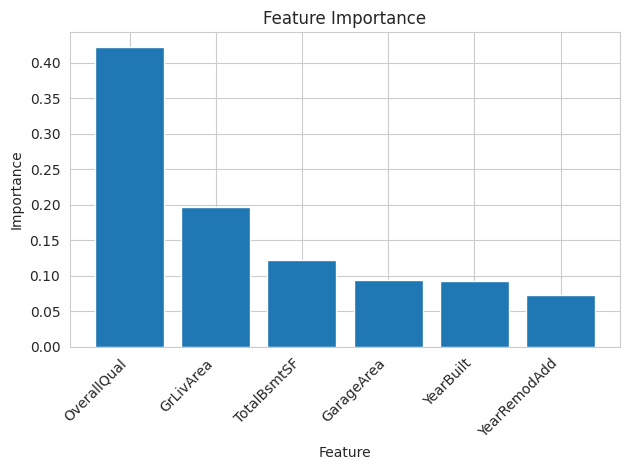

In [58]:
# Sort the features by importance for better visualization 
df_feature_importance = df_feature_importance.sort_values(by="Importance", ascending=False)

# Create bar plot
plt.bar(df_feature_importance["Feature"], df_feature_importance["Importance"])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
